# ID2214 Assignment 4 Group no. 5
### Project members: 
[Piriya Sureshkumar, piriya@kth.se]
[Pablo Laso, plaso@kth.se]
[Lucas Trouessin, lucastr@kth.se]

## Loading data

#### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import time

from rdkit import Chem
from rdkit.Chem import Lipinski, Fragments, rdMolDescriptors

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import cross_val_score, cross_validate, validation_curve, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import ttest_ind_from_stats

t0 = time.perf_counter()
warnings.filterwarnings("ignore")
sns.set_theme()

#### Feature extraction

In [2]:
def extract_features(data):
    t1 = time.perf_counter()
    
    df = data.copy()
        
    # Generate molecules
    df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
    
    # Get libraries functions
    fragm = dir(Fragments)
    lipin = dir(Lipinski)
    rdMol = dir(rdMolDescriptors)
    
    # Go through libraries and add a column per feature
    for func in fragm:
        try:
            df['fragm_'+func] = df['mol'].apply(lambda x: getattr(Chem.Fragments, func)(x))
        except: continue

    for func in lipin:
        try:
            df['lipin_'+func] = df['mol'].apply(lambda x: getattr(Chem.Lipinski, func)(x))
        except: continue

    for func in rdMol:
        try:
            df['rdMol_'+func] = df['mol'].apply(lambda x: getattr(Chem.rdMolDescriptors, func)(x))
        except: continue
    
    df.to_csv('data_features_all.csv',sep=',')
    
    print("Feature extraction time: {:.2f} min.".format((time.perf_counter()-t1)/60))
    return df

In [3]:
# Import data, extract features
# train_df = pd.read_csv("training_smiles.csv",index_col=0)
# df = extract_features(train_df)

df = pd.read_csv('data_features_all.csv',index_col=0)

#### Data preparation

In [4]:
df = df.select_dtypes(include=np.number)
df.dropna(axis=0, how='any', inplace=True)

# Features & labels
X = df.drop(['ACTIVE'],axis=1)
labels = list(X.columns)
y = df['ACTIVE']
display(X.head(3))

# Normalization
# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaler = RobustScaler()

scaler.fit(X)
X = pd.DataFrame(scaler.transform(X),columns=labels)
display(X.head(3))

,fragm_fr_Al_COO,fragm_fr_Al_OH,fragm_fr_Al_OH_noTert,fragm_fr_ArN,fragm_fr_Ar_COO,fragm_fr_Ar_N,fragm_fr_Ar_NH,fragm_fr_Ar_OH,fragm_fr_COO,fragm_fr_COO2,...,rdMol_CalcNumRings,rdMol_CalcNumRotatableBonds,rdMol_CalcNumSaturatedCarbocycles,rdMol_CalcNumSaturatedHeterocycles,rdMol_CalcNumSaturatedRings,rdMol_CalcNumSpiroAtoms,rdMol_CalcNumUnspecifiedAtomStereoCenters,rdMol_CalcPhi,rdMol_CalcTPSA,rdMol__CalcMolWt
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,2,5,0,0,0,0,0,5.522679,50.36,338.451
2,0,0,0,0,0,0,0,1,0,0,...,2,8,0,0,0,0,1,7.052794,40.54,339.479
3,0,0,0,0,0,0,0,0,0,0,...,2,3,0,1,1,0,1,3.718405,70.23,233.271


,fragm_fr_Al_COO,fragm_fr_Al_OH,fragm_fr_Al_OH_noTert,fragm_fr_ArN,fragm_fr_Ar_COO,fragm_fr_Ar_N,fragm_fr_Ar_NH,fragm_fr_Ar_OH,fragm_fr_COO,fragm_fr_COO2,...,rdMol_CalcNumRings,rdMol_CalcNumRotatableBonds,rdMol_CalcNumSaturatedCarbocycles,rdMol_CalcNumSaturatedHeterocycles,rdMol_CalcNumSaturatedRings,rdMol_CalcNumSpiroAtoms,rdMol_CalcNumUnspecifiedAtomStereoCenters,rdMol_CalcPhi,rdMol_CalcTPSA,rdMol__CalcMolWt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,...,0.095238,0.116279,0.0,0.000000,0.000000,0.0,0.000000,0.065193,0.057332,0.176093
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,...,0.095238,0.186047,0.0,0.000000,0.000000,0.0,0.029412,0.083297,0.046153,0.176686
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,...,0.095238,0.069767,0.0,0.047619,0.047619,0.0,0.029412,0.043845,0.079953,0.115451


## Feature selection

In [5]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [6]:
# Hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)
y_train.value_counts()

0.0    118514
1.0       338
Name: ACTIVE, dtype: int64

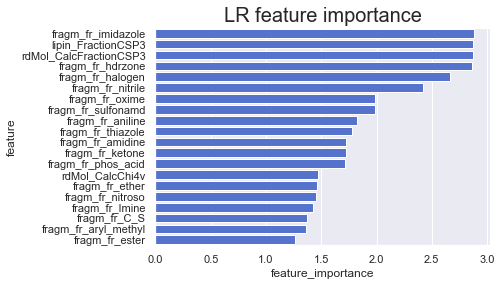

In [7]:
# LR feature selection

lr = LogisticRegression()
lr.fit(X_train,y_train)
feature_importances_= np.abs(lr.coef_)[0]
base_imp = imp_df(X_train.columns,feature_importances_)
var_imp_plot(base_imp[:20], 'LR feature importance')
lr_features=base_imp[:50]['feature']

Elapsed time since the beginning: 2.91 min.


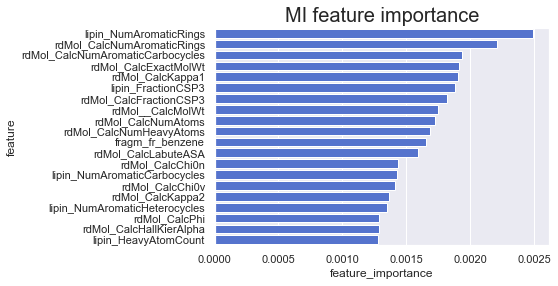

In [8]:
# MI feature selection

X_mi = SelectKBest(mutual_info_classif, k=50).fit(X_train, y_train)

feature_importances_ = X_mi.scores_
base_imp = imp_df(X_train.columns,feature_importances_)
var_imp_plot(base_imp[:20], 'MI feature importance')
mi_features=base_imp[:50]['feature']

print("Elapsed time since the beginning: {:.2f} min.".format((time.perf_counter()-t0)/60))

In [9]:
common_features= pd.merge(mi_features, lr_features, how='inner', on='feature')
common_features

,feature
0,rdMol_CalcExactMolWt
1,rdMol_CalcKappa1
2,lipin_FractionCSP3
3,rdMol_CalcFractionCSP3
4,rdMol__CalcMolWt
5,rdMol_CalcLabuteASA
6,rdMol_CalcChi3v
7,rdMol_CalcChi2v
8,lipin_NumRotatableBonds
9,rdMol_CalcNumRotatableBonds


## Data exploration

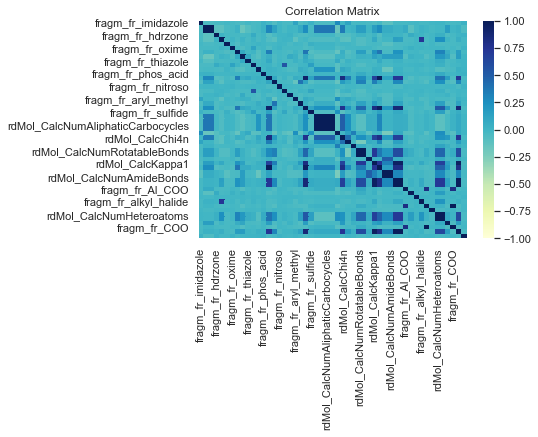

In [10]:
# Correlation
features = lr_features.to_list()
features.append('ACTIVE')
sns.heatmap(df[features].corr(),vmin=-1, vmax=1,cmap="YlGnBu");
plt.title('Correlation Matrix');

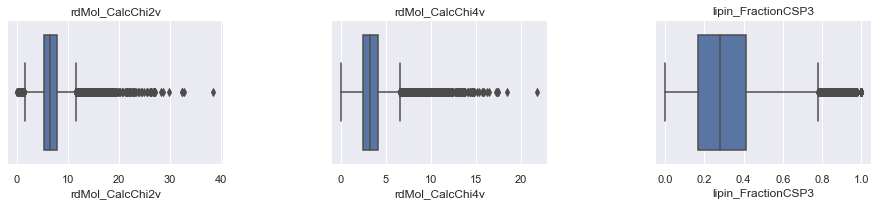

In [11]:
# Boxplots
fig, ax = plt.subplots(1,3, figsize=(10,2))
plt.subplots_adjust(left=0, bottom=0, right=1.2, top=10, wspace=0.5, hspace=0.5)
for num,col in enumerate(['rdMol_CalcChi2v','rdMol_CalcChi4v','lipin_FractionCSP3']):
    plt.subplot(7,3,num+1)
    sns.boxplot(x=df[col]);
    plt.title(col)

## Sampling

In [12]:
X_train.shape

(118852, 149)

In [13]:
# Oversampling

oversample = SMOTE(sampling_strategy=0.6)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [14]:
y_train.value_counts()

0.0    118514
1.0     71108
Name: ACTIVE, dtype: int64

In [15]:
# Reduce the training size (but keep the data non-oversampled for the tests)
X_train, X_t, y_train, y_t = train_test_split(X_train, y_train, stratify=y_train, test_size=0.95, random_state=42)

# Count
display(y_train.value_counts())

# Proportions
display(y_train.value_counts()/len(y_train))

0.0    5926
1.0    3555
Name: ACTIVE, dtype: int64

0.0    0.62504
1.0    0.37496
Name: ACTIVE, dtype: float64

## Model tuning

In [16]:
random_state=2
models_names=['Logistic Regression', 'KNN Classifier', 'Decision Tree Classifier', "Neural Network Classifier", "Random Forest Classifier"]
clfs= [LogisticRegression(solver='liblinear', random_state=random_state), KNeighborsClassifier(),
           DecisionTreeClassifier(random_state=random_state),MLPClassifier(random_state=random_state), RandomForestClassifier(random_state=random_state)]
params={0: {'penalty':['l1', 'l2'], 'C': np.arange(0.01, 1, 0.01)}, 
       1: {'n_neighbors':np.arange(1, 10, 1), 'metric':['euclidean','manhattan'], 'weights': ['uniform', 'distance']},
       2: {'criterion':['gini', 'entropy'], 'max_depth':np.arange(2,4,1), 'min_samples_leaf': np.arange(10,20,1)}, 
       3: {'hidden_layer_sizes': [(22,), (22, 22)], 'solver':['sgd', 'adam'], 'activation':['logistic', 'tanh', 'relu']},
       4: {'criterion':['gini', 'entropy'], 'max_depth':np.arange(1,4,1), "min_samples_leaf": np.arange(3,10,1)}}


def Grid_Search_cv(model_index, X, y):
    
    grid = GridSearchCV(clfs[model_index], params[model_index], verbose = 0, cv = 5, n_jobs = -1, return_train_score = True)

    grid_results = grid.fit(X, y)
    
    return grid_results.best_estimator_.get_params()


def param_tuning(X_train, y_train):
    random_state=2

    best_params_lr = Grid_Search_cv(0, X_train, y_train)
    best_params_kn = Grid_Search_cv(1, X_train, y_train)
    best_params_dt = Grid_Search_cv(2, X_train, y_train)
    best_params_nn = Grid_Search_cv(3, X_train, y_train)
    best_params_rf = Grid_Search_cv(4, X_train, y_train)

    best_params_=[best_params_lr, best_params_kn, best_params_dt, best_params_nn, best_params_rf]

    for i in range(len(models_names)):
        print(" ")
        print('\033[1m' + 'Best parameter for ' + str(models_names[i]) +'\033[0m')
        print(best_params_[i])
    
    return best_params_

def model_building(X_train, y_train, X_test, y_test):

    train_accuracy=[]
    train_auc=[]

    cv_accuracy=[]
    cv_auc=[]

    test_accuracy=[]
    test_auc=[]

    auc_mean_list=[]
    auc_std_list=[]
    
    best_params_= param_tuning(X_train, y_train)
    
    for ix in range(len(models_names)):

        original_model=clone(clfs[ix])

        optimized_model=clone(clfs[ix]).set_params(**best_params_[ix])

        models=[optimized_model, original_model]

        for model in models:

            model = clone(model)

            model.fit(X_train, y_train)

            #--Train scores
            y_pred_train = model.predict(X_train)
            train_accuracy.append(accuracy_score(y_train, y_pred_train))
            train_auc.append(roc_auc_score(y_train, y_pred_train))

            #--Validation scores
            cv_results = cross_validate(model, X_train, y_train, scoring=["accuracy", "roc_auc"])
            cv_accuracy.append(abs(np.mean(cv_results['test_accuracy'])))
            
            auc_mean=abs(np.mean(cv_results['test_roc_auc']))
            auc_mean_list.append(auc_mean)
            auc_std=abs(np.std(cv_results['test_roc_auc']))
            auc_std_list.append(auc_std)
            cv_auc.append(auc_mean)
        
            #--Test scores
            y_pred_test = model.predict(X_test)
            test_accuracy.append(accuracy_score(y_test, y_pred_test))
            test_auc.append(roc_auc_score(y_test, y_pred_test))
        
    index_names=['Logistic Regression Tuned', 'Logistic Regression', 'KNN Classifier Tuned', 'KNN Classifier', 
                'Decision Tree Classifier Tuned', 'Decision Tree Classifier', 'Neural Network Classifier Tuned', 'Neural Network Classifier',
                'Random Forest Classifier Tuned', 'Random Forest Classifier']
    
    ttest_data = pd.DataFrame(
            {'mean':auc_mean_list,
             'std': auc_std_list                    
            })
    
    ttest_data.index=index_names

    ht_results = pd.DataFrame(list(zip(train_accuracy, train_auc, cv_accuracy, 
                                       cv_auc, test_accuracy, test_auc)), columns=["Train Accuracy", "Train AUC |", 
                                                                                    "| Val. acc.", "Valid. AUC |",
                                                                                       "| Test Acc", "Test AUC"])
    ht_results.index=index_names
    
    return ht_results, ttest_data

In [17]:
t1=time.perf_counter()

ht_results_lr,ttest_data_lr=model_building(X_train[lr_features], y_train, X_test[lr_features], y_test)
ht_results_lr

 
Best parameter for Logistic Regression
{'C': 0.93, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 2, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
 
Best parameter for KNN Classifier
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
 
Best parameter for Decision Tree Classifier
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 2, 'splitter': 'best'}
 
Best parameter for Neural Network Classifier
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'ea

,Train Accuracy,Train AUC |,| Val. acc.,Valid. AUC |,| Test Acc,Test AUC
Logistic Regression Tuned,0.856344,0.849574,0.854340,0.919825,0.868239,0.838965
Logistic Regression,0.848856,0.840601,0.847800,0.915165,0.867364,0.814784
KNN Classifier Tuned,1.000000,1.000000,0.969307,0.973984,0.955541,0.704674
KNN Classifier,0.952642,0.961891,0.926063,0.977226,0.887558,0.759619
Decision Tree Classifier Tuned,0.837992,0.824145,0.837148,0.866829,0.864268,0.700457
Decision Tree Classifier,1.000000,1.000000,0.945469,0.944111,0.961633,0.612761
Neural Network Classifier Tuned,0.954224,0.953140,0.927223,0.974614,0.933396,0.741054
Neural Network Classifier,0.962135,0.965320,0.943360,0.981765,0.933060,0.729015
Random Forest Classifier Tuned,0.836093,0.819419,0.833139,0.916238,0.874398,0.794569
Random Forest Classifier,1.000000,1.000000,0.980698,0.998078,0.985259,0.660220


In [18]:
print("Elapsed time for model building: {:.2f} min.".format((time.perf_counter()-t1)/60))

Elapsed time for model building: 7.14 min.


## Model uncertainty

In [19]:
ttest_data_lr

,mean,std
Logistic Regression Tuned,0.919825,0.005738
Logistic Regression,0.915165,0.005262
KNN Classifier Tuned,0.973984,0.003423
KNN Classifier,0.977226,0.003276
Decision Tree Classifier Tuned,0.866829,0.005360
Decision Tree Classifier,0.944111,0.007583
Neural Network Classifier Tuned,0.974614,0.003143
Neural Network Classifier,0.981765,0.002962
Random Forest Classifier Tuned,0.916238,0.005004
Random Forest Classifier,0.998078,0.000438


In [20]:
def ttest(dataframe):
    p_value = []
    tstatistic = []
    for i in range(5):
        a,b = ttest_ind_from_stats(mean1=dataframe['mean'][2*i], std1=dataframe['std'][2*i], nobs1=5,
                             mean2=dataframe['mean'][2*i+1], std2=dataframe['std'][2*i+1], nobs2=5)
        tstatistic.append(a)
        p_value.append(b)
    
    return p_value, tstatistic

In [21]:
ttest(ttest_data_lr)

([0.21752568798646948,
  0.16455669287284294,
  7.173874938964959e-08,
  0.00602208278111155,
  3.5332561463506515e-10],
 [1.3384938666830852,
  -1.529955589296714,
  -18.608810942156794,
  -3.7023655145788594,
  -36.42971375183689])

## Generate predictions

#### Prepare data

In [22]:
def prepare_data(data,scaler,lr_features):
    test_df=data.copy()

    # Get features
    test_df = extract_features(test_df).select_dtypes(include=np.number)
    labels = list(test_df.columns)

    # Normalize
    test_df = pd.DataFrame(scaler.transform(test_df),columns=labels)

    # Keep selected features
    test_df = test_df[lr_features]

    test_df.to_csv('test_data_prepared.csv',sep=',')
    
    return test_df

In [23]:
# Read data, then prepare it
# test_df = pd.read_csv("test_smiles.csv",index_col = 0)
# test_df = prepare_data(test_df,scaler,lr_features)

test_df = pd.read_csv("test_data_prepared.csv",index_col=0)

test_df.head(3)

,fragm_fr_imidazole,lipin_FractionCSP3,rdMol_CalcFractionCSP3,fragm_fr_hdrzone,fragm_fr_halogen,fragm_fr_nitrile,fragm_fr_oxime,fragm_fr_sulfonamd,fragm_fr_aniline,fragm_fr_thiazole,...,fragm_fr_nitro_arom,fragm_fr_azo,fragm_fr_alkyl_halide,fragm_fr_COO2,fragm_fr_aldehyde,rdMol_CalcNumHeteroatoms,lipin_NumHeteroatoms,fragm_fr_piperzine,fragm_fr_COO,rdMol_CalcLabuteASA
0,0.0,0.733333,0.733333,0.0,0.000,0.0,0.0,0.0,0.285714,0.00,...,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,0.0,0.143889
1,0.0,0.428571,0.428571,0.0,0.125,0.0,0.0,0.0,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.100000,0.100000,0.0,0.0,0.160931
2,0.0,0.250000,0.250000,0.0,0.000,0.0,0.0,0.0,0.000000,0.25,...,0.0,0.0,0.0,0.0,0.0,0.083333,0.083333,0.0,0.0,0.228696


#### Predict

In [24]:
# Prepare training data with the same oversampling, on the selected features
X, y = oversample.fit_resample(X[lr_features], y)
y.value_counts()

0.0    148143
1.0     88885
Name: ACTIVE, dtype: int64

In [26]:
# Train final model
params = {'C': 0.93, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 2, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
# params = {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 6, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 2, 'verbose': 0, 'warm_start': False}
t1=time.perf_counter()

model = LogisticRegression(**params)
# model = RandomForestClassifier(**params)
model.fit(X,y)

print("Training time: {:.2f} min.".format((time.perf_counter()-t1)/60))

Training time: 1.99 min.


In [27]:
proba = model.predict_proba(test_df)
proba = pd.DataFrame(proba, columns=['0','1'])['1'].values

# display(pd.DataFrame(model.predict(test_df)).value_counts()/len(test_df))

textfile = open('5.txt', 'w')
textfile.write('0.839')
for t in proba:
    textfile.write('\n' + "{:e}".format(t))
textfile.close()

In [28]:
print("Total execution time: {:.2f} min.".format((time.perf_counter()-t0)/60))

Total execution time: 14.68 min.
